### 이벤트 아티스트 발굴 모델링
- 아티스트별로 최적화된 이벤트를 기획하기 위한 클러스터링 분석 및 모델 작업

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.4.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


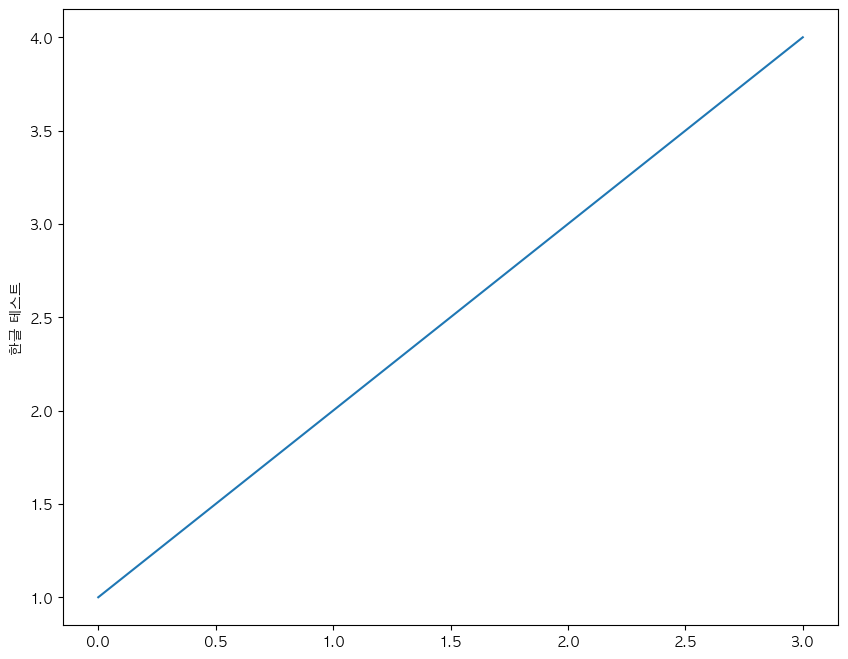

In [1]:
## import library
import trino
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


plt.rcParams['figure.figsize'] = [10, 8]

conn = trino.dbapi.connect(
    host='kakaoent-presto-adhoc.kakaoent.io',
    port=8443,
    user='samuel-ch',
    catalog='hadoop_kent',
    schema='default',                          # 사용할 Database 지정
    http_scheme='https',
    auth=trino.auth.BasicAuthentication("samuel-ch", "melon!Q2w3e"),  # 카카오 LDAP이 아닌 하둡 LDAP 입력
    http_headers={
        'X-Presto-User': 'samuel-ch',
        'X-Presto-Time-Zone': 'Asia/Seoul'
    },
)
cur = conn.cursor()

# Set CSS properties for th elements in dataframe
th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '11px')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

cm = sns.light_palette("green", as_cmap=True)

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# AppleGothic 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'

# 테스트 플롯
plt.plot([1, 2, 3, 4])
plt.ylabel('한글 테스트')
plt.show()

### 이벤트 아티스트 
- 22년도 데뷔후 주요 아티스트들의 팬덤 분포(연령대,성별)
- 남자 순위 여자순위.
- 남성 비중, 여성비중 ~ 팬덤 사용자 증감 상관계수

In [2]:
# 남성,여성비중 증감과 팬덤 사용자 증감 상관성 분석 
fandom_user_gndr_query = '''
    select t1.artist_id
         , t2.artist_name_web_list
         , t2.debut_day
         , t1.dt
         , t1.user_cnt 
         , t1.male_user_cnt
         , t1.female_user_cnt
         , cast(t1.female_user_cnt as double)/t1.user_cnt*100 as female_user_ratio
         , t1.age_102030_user_cnt
         , cast(t1.age_102030_user_cnt as double)/t1.user_cnt*100 as age_102030_user_ratio
    from(
        select artist_id             
             , date(date_parse(log_date,'%Y%m%d')) as dt
             , count(distinct A.member_key) as user_cnt
             , count(distinct if(MEMBER_GNDR = 1,A.member_key)) as male_user_cnt
             , count(distinct if(MEMBER_GNDR = 2,A.member_key)) as female_user_cnt
             , count(distinct if(AGE_ENT_PRT_CD in (1,23,4,5,6),A.member_key)) as age_102030_user_cnt
        from HADOOP_KENT.MELON_MA_PROD_PRODUCTION.A_USER_ARTIST_FANDOM_TRGT_DAY  A
        left join(
            select MEMBER_KEY
                 , MEMBER_GNDR
                 , AGE_ENT_PRT_CD
            from HADOOP_KENT.MELON_MA_TMK_PRODUCTION.A_USER_PROFILE_DAY
            where log_date = '20250511'
            GROUP BY 1,2,3
        ) B on A.member_key = B.member_key
        where log_date between '20240101' and '20250511'
        and (CONTAINS(FANDOM_TYPE,'A')=true OR CONTAINS(FANDOM_TYPE,'B')=true OR CONTAINS(FANDOM_TYPE,'C')=true)
        and artist_id in (3207401,3466604,3458776,3478478,3114174,3180539,3064111,3092950,3070786,3610529,3743525,3457231,3156910,2399724)
        and B.member_key is not null
        group by 1,2
    ) t1    
    left join hadoop_kent.melon_ods_meta_production.pb_artist_dtl_tb_ro t2 on t1.artist_id = t2.artist_id
    order by 1,4
'''

cur.execute(fandom_user_gndr_query)

results = cur.fetchall()
colnames = [part[0] for part in cur.description]

fandom_user_gndr = pd.DataFrame(results, columns=colnames)

cur.cancel()
conn.close()
fandom_user_gndr.head()

,artist_id,artist_name_web_list,debut_day,dt,user_cnt,male_user_cnt,female_user_cnt,female_user_ratio,age_102030_user_cnt,age_102030_user_ratio
0,2399724,YENA (최예나),20220117,2024-01-01,2894,1606,1288,44.505874,1101,38.044229
1,2399724,YENA (최예나),20220117,2024-01-02,2893,1606,1287,44.486692,1101,38.057380
2,2399724,YENA (최예나),20220117,2024-01-03,2894,1607,1287,44.471320,1101,38.044229
3,2399724,YENA (최예나),20220117,2024-01-04,2893,1607,1286,44.452126,1101,38.057380
4,2399724,YENA (최예나),20220117,2024-01-05,2893,1607,1286,44.452126,1101,38.057380


    artist_name_web_list  male_corr  female_corr
0            BOYNEXTDOOR   0.934122     0.999043
1            FIFTY FIFTY   0.988347     0.981014
2           H1-KEY (하이키)   0.986073     0.989127
3     LE SSERAFIM (르세라핌)   0.990987     0.994317
4                  NMIXX   0.984084     0.973457
5               NewJeans   0.964663     0.994484
6                  PLAVE   0.948884     0.999501
7                   QWER   0.982112     0.860525
8                  RIIZE   0.936901     0.999255
9             YENA (최예나)   0.999135     0.998519
10  ZEROBASEONE (제로베이스원)   0.808898     0.953284
11                아이리 칸나   0.987252     0.795778
12            아일릿(ILLIT)   0.983038     0.996509
13                   황영웅   0.828244     0.997023


/var/folders/qw/6lks7c5d14scf7qtctm8m6jh0000gn/T/ipykernel_50584/86026136.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_results = correlation_data.groupby('artist_name_web_list').apply(


<Figure size 1200x800 with 0 Axes>

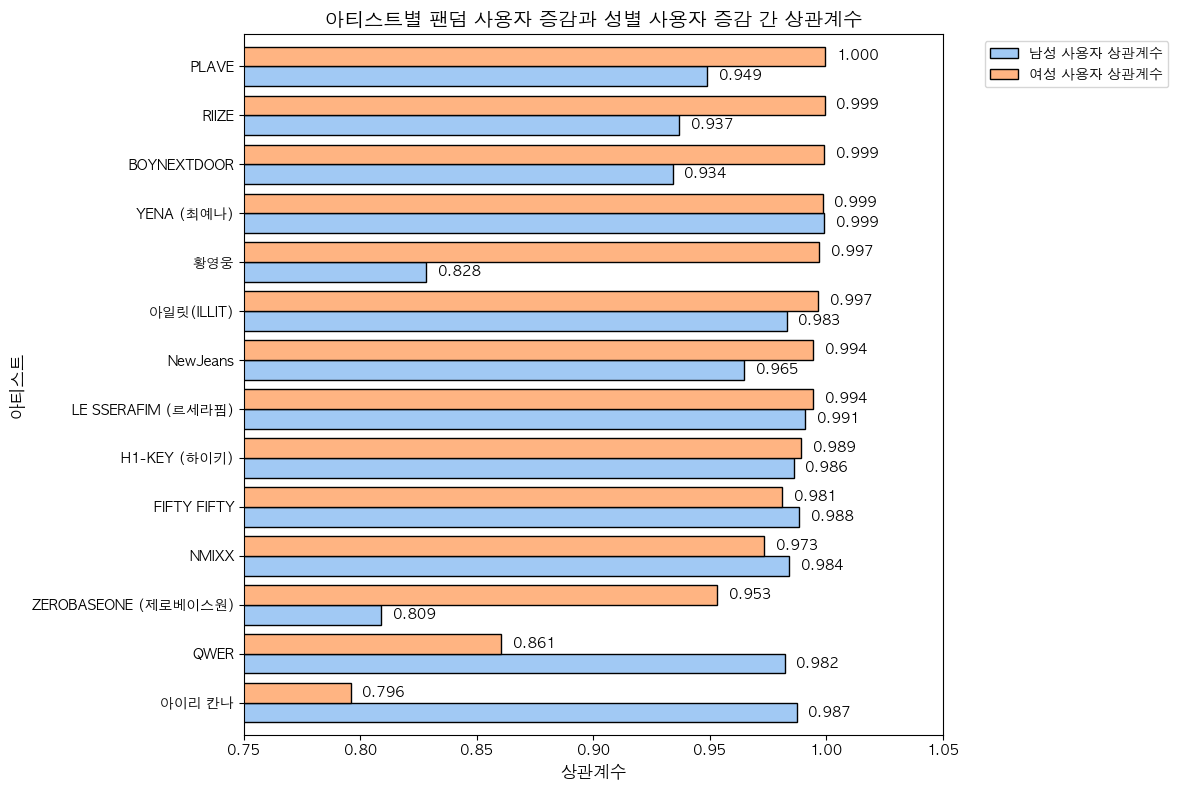

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 로드 (fandom_user_gndr 데이터프레임이 이미 준비되어 있다고 가정)
# fandom_user_gndr = pd.DataFrame(...) 

# 남성 사용자 증감과 여성 사용자 증감을 계산
fandom_user_gndr['male_user_diff'] = fandom_user_gndr.groupby('artist_name_web_list')['male_user_cnt'].diff()
fandom_user_gndr['female_user_diff'] = fandom_user_gndr.groupby('artist_name_web_list')['female_user_cnt'].diff()
fandom_user_gndr['user_diff'] = fandom_user_gndr.groupby('artist_name_web_list')['user_cnt'].diff()

# 상관성 분석을 위한 데이터 필터링 (NaN 제거)
correlation_data = fandom_user_gndr.dropna(subset=['male_user_diff', 'female_user_diff', 'user_diff'])

# 아티스트별 상관계수 계산
correlation_results = correlation_data.groupby('artist_name_web_list').apply(
    lambda group: pd.Series({
        'male_corr': group['user_diff'].corr(group['male_user_diff']),
        'female_corr': group['user_diff'].corr(group['female_user_diff'])
    })
).reset_index()

# 결과 출력
print(correlation_results)

# 여성 사용자 상관계수 기준으로 내림차순 정렬
correlation_results_sorted = correlation_results.sort_values(by='female_corr', ascending=True)

# 시각화: 아티스트별 상관계수 비교 (수평 막대 그래프)
plt.figure(figsize=(12, 8))
ax = correlation_results_sorted.set_index('artist_name_web_list')[['male_corr', 'female_corr']].plot(
    kind='barh', figsize=(12, 8), color=sns.color_palette("pastel", 2), edgecolor='black', width=0.8
)

plt.title('아티스트별 팬덤 사용자 증감과 성별 사용자 증감 간 상관계수', fontsize=14)
plt.xlabel('상관계수', fontsize=12)
plt.ylabel('아티스트', fontsize=12)

# x축 범위를 0.75~1.0으로 설정
plt.xlim(0.75, 1.05)

# 각 막대 끝에 상관계수 값 추가
for bars, corr_label in zip(ax.containers, ['male_corr', 'female_corr']):
    for bar in bars:
        width = bar.get_width()
        plt.text(
            width + 0.005,  # 막대 끝에서 약간 오른쪽으로 위치
            bar.get_y() + bar.get_height() / 2,  # 막대의 중앙에 위치
            f'{width:.3f}',  # 소수점 두 자리까지 표시
            ha='left', va='center', fontsize=10, color='black'
        )

# 범례를 그래프 바깥으로 이동
plt.legend(['남성 사용자 상관계수', '여성 사용자 상관계수'], fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

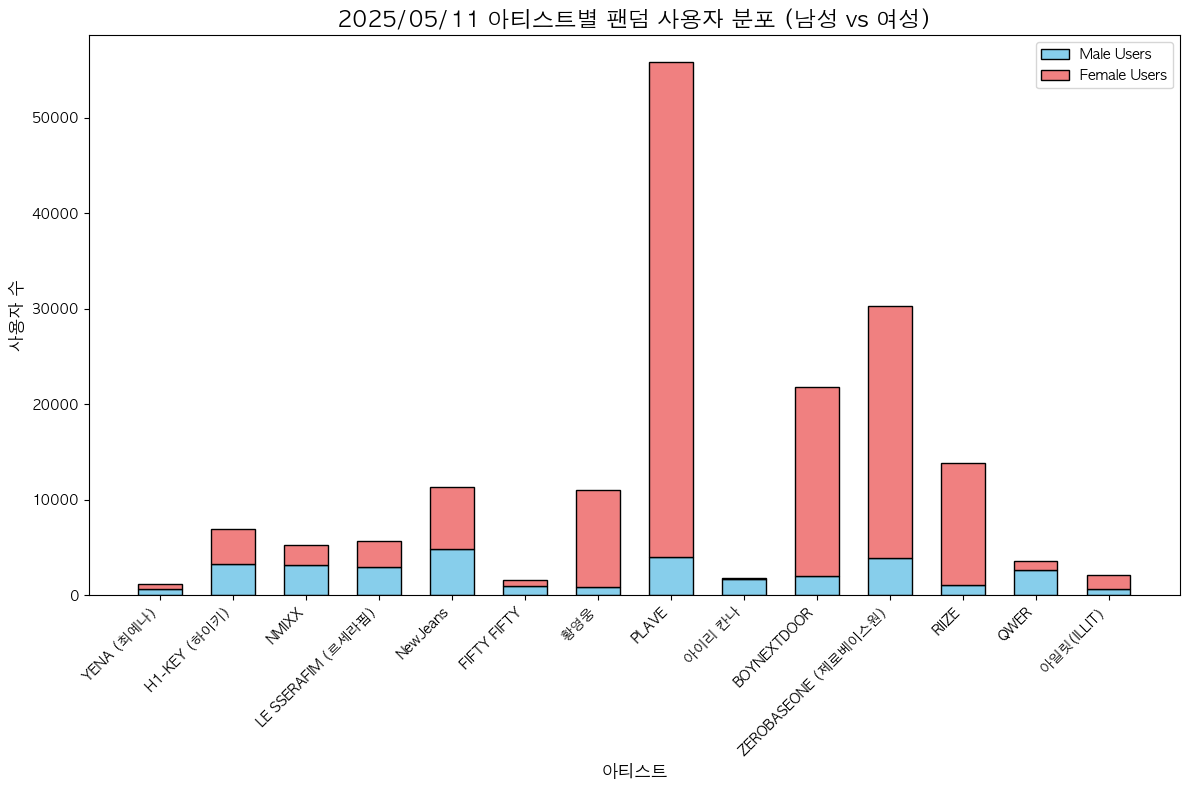

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# 'dt' 컬럼의 데이터 타입 확인 및 변환
if fandom_user_gndr['dt'].dtype == 'object':
    fandom_user_gndr['dt'] = pd.to_datetime(fandom_user_gndr['dt'], errors='coerce')

# 2025/05/11 데이터 필터링
latest_date = '2025-05-11'
filtered_data = fandom_user_gndr[fandom_user_gndr['dt'] == latest_date].copy()

# 스택형 바 플롯 생성
plt.figure(figsize=(12, 8))
bar_width = 0.6

# 남성 사용자와 여성 사용자 데이터
male_users = filtered_data['male_user_cnt']
female_users = filtered_data['female_user_cnt']
artists = filtered_data['artist_name_web_list']

# 스택형 바 플롯
plt.bar(artists, male_users, label='Male Users', color='skyblue', edgecolor='black', width=bar_width)
plt.bar(artists, female_users, bottom=male_users, label='Female Users', color='lightcoral', edgecolor='black', width=bar_width)

# 그래프 꾸미기
plt.title('2025/05/11 아티스트별 팬덤 사용자 분포 (남성 vs 여성)', fontsize=16)
plt.xlabel('아티스트', fontsize=12)
plt.ylabel('사용자 수', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(fontsize=10)
plt.tight_layout()

# 그래프 출력
plt.show()

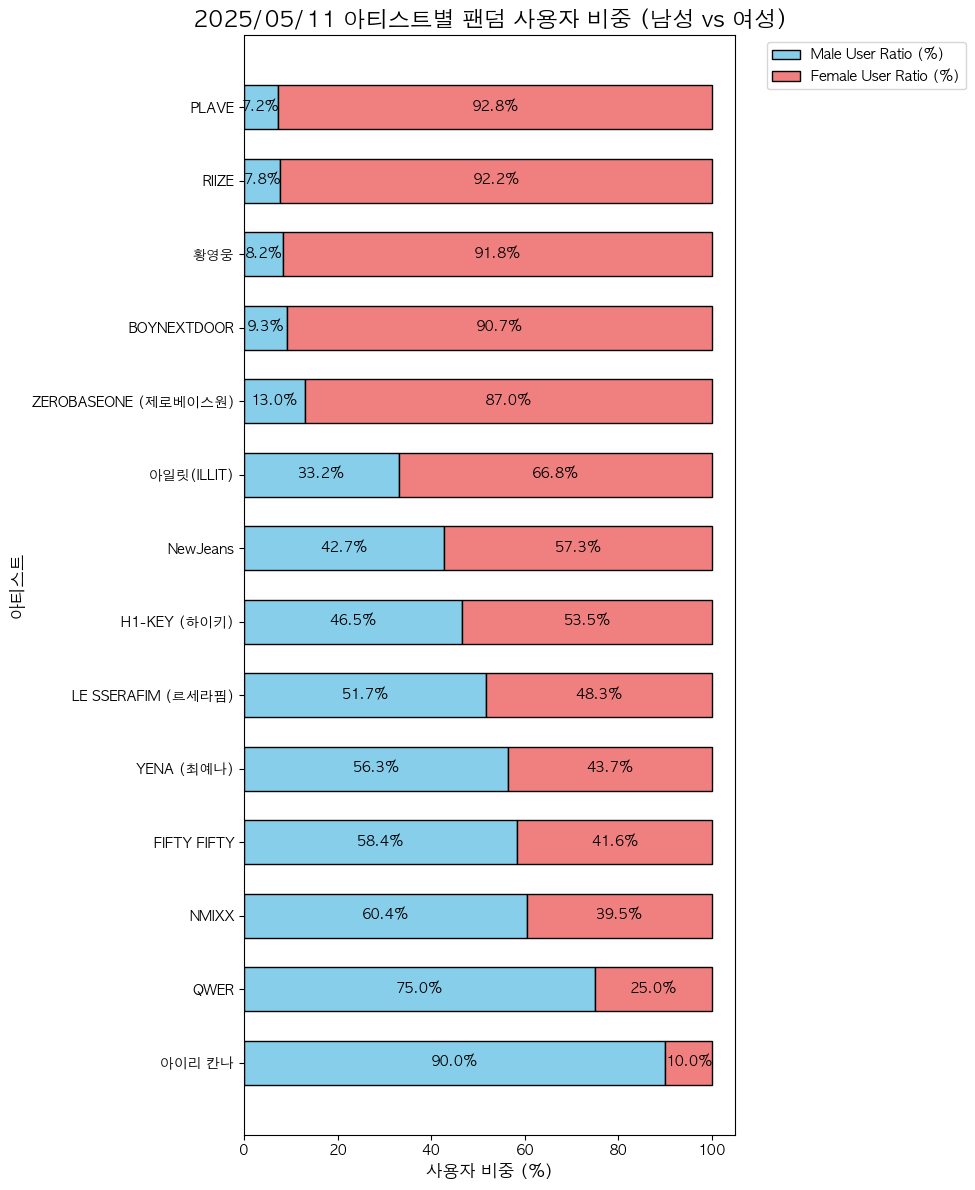

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# 'dt' 컬럼의 데이터 타입 확인 및 변환
if fandom_user_gndr['dt'].dtype == 'object':
    fandom_user_gndr['dt'] = pd.to_datetime(fandom_user_gndr['dt'], errors='coerce')

# 2025/05/11 데이터 필터링
latest_date = '2025-05-11'
filtered_data = fandom_user_gndr[fandom_user_gndr['dt'] == latest_date].copy()

# 여성 사용자 비중과 남성 사용자 비중 계산
#filtered_data['female_user_ratio'] = (filtered_data['female_user_cnt'] / filtered_data['user_cnt']) * 100
filtered_data['male_user_ratio'] = (filtered_data['male_user_cnt'] / filtered_data['user_cnt']) * 100

# 여성 사용자 상관계수 기준으로 내림차순 정렬
filtered_data = filtered_data.sort_values(by='female_user_ratio', ascending=True)

# 스택형 바 플롯 생성 (x축과 y축 전환)
plt.figure(figsize=(10, 12))
bar_width = 0.6

# 남성 사용자 비중과 여성 사용자 비중 데이터
male_ratios = filtered_data['male_user_ratio']
female_ratios = filtered_data['female_user_ratio']
artists = filtered_data['artist_name_web_list']

# 스택형 바 플롯 (x축과 y축 전환)
plt.barh(artists, male_ratios, label='Male User Ratio (%)', color='skyblue', edgecolor='black', height=bar_width)
plt.barh(artists, female_ratios, left=male_ratios, label='Female User Ratio (%)', color='lightcoral', edgecolor='black', height=bar_width)

# 영역별 비율 표시
for i, (male, female) in enumerate(zip(male_ratios, female_ratios)):
    plt.text(male / 2, i, f'{male:.1f}%', ha='center', va='center', fontsize=10, color='black')  # 남성 비율
    plt.text(male + female / 2, i, f'{female:.1f}%', ha='center', va='center', fontsize=10, color='black')  # 여성 비율

# 그래프 꾸미기
plt.title('2025/05/11 아티스트별 팬덤 사용자 비중 (남성 vs 여성)', fontsize=16)
plt.xlabel('사용자 비중 (%)', fontsize=12)
plt.ylabel('아티스트', fontsize=12)
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1))  # 레전드를 그래프 바깥으로 이동
plt.tight_layout()

# 그래프 출력
plt.show()

datetime64[ns]


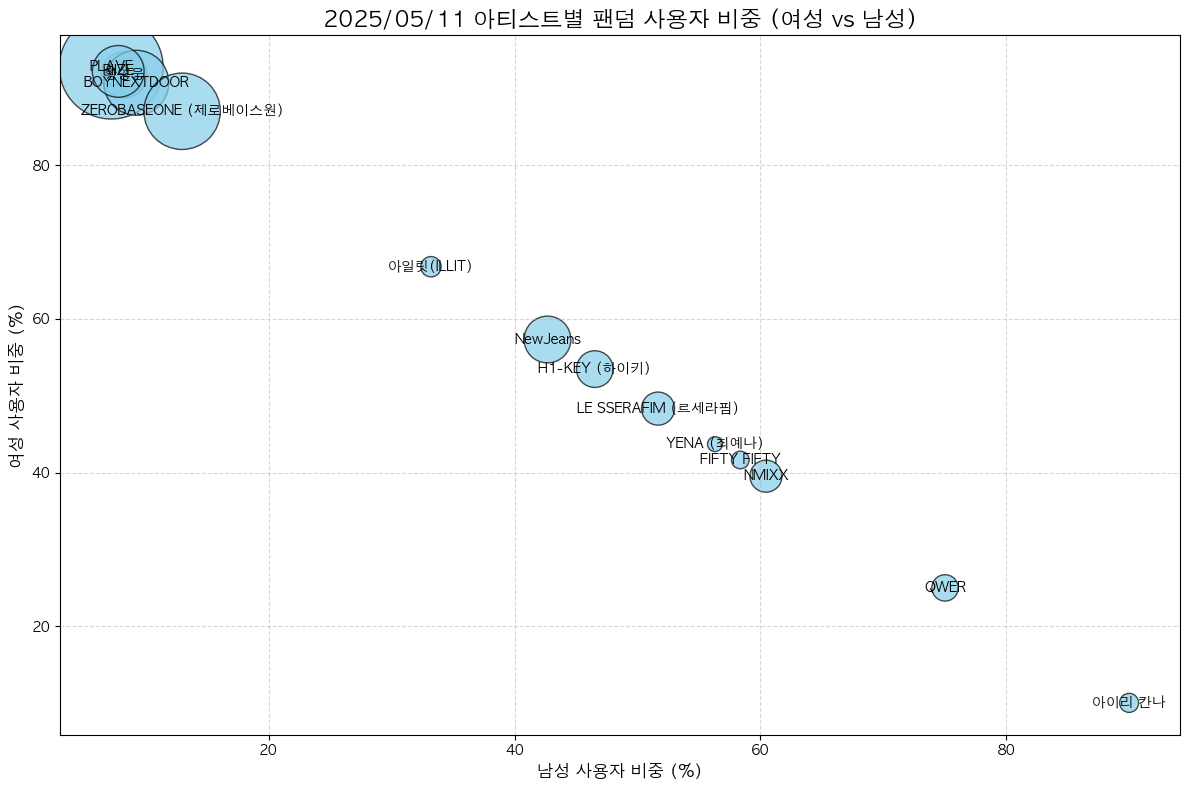

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 'dt' 컬럼의 데이터 타입 확인
print(fandom_user_gndr['dt'].dtype)

# 'dt' 컬럼이 문자열이라면 datetime으로 변환
if fandom_user_gndr['dt'].dtype == 'object':
    fandom_user_gndr['dt'] = pd.to_datetime(fandom_user_gndr['dt'], errors='coerce')

# 2025/05/11 데이터 필터링
latest_date = '2025-05-11'
filtered_data = fandom_user_gndr[fandom_user_gndr['dt'] == latest_date].copy()

# 여성 사용자 비중과 남성 사용자 비중 계산
filtered_data['female_user_ratio'] = (filtered_data['female_user_cnt'] / filtered_data['user_cnt']) * 100
filtered_data['male_user_ratio'] = (filtered_data['male_user_cnt'] / filtered_data['user_cnt']) * 100

# Scatter plot 생성
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    filtered_data['male_user_ratio'], 
    filtered_data['female_user_ratio'],     
    s=filtered_data['user_cnt'] / 10,  # 팬덤 사용자 수에 비례한 점 크기
    alpha=0.7, 
    c='skyblue', 
    edgecolor='black'
)

# 각 점에 아티스트 이름 추가
for i, row in filtered_data.iterrows():
    plt.text(
        row['male_user_ratio'], 
        row['female_user_ratio'],         
        row['artist_name_web_list'], 
        fontsize=10, 
        ha='center', 
        va='center'
    )

# 그래프 꾸미기
plt.title('2025/05/11 아티스트별 팬덤 사용자 비중 (여성 vs 남성)', fontsize=16)
plt.xlabel('남성 사용자 비중 (%)', fontsize=12)
plt.ylabel('여성 사용자 비중 (%)', fontsize=12)
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()

# 그래프 출력
plt.show()

datetime64[ns]


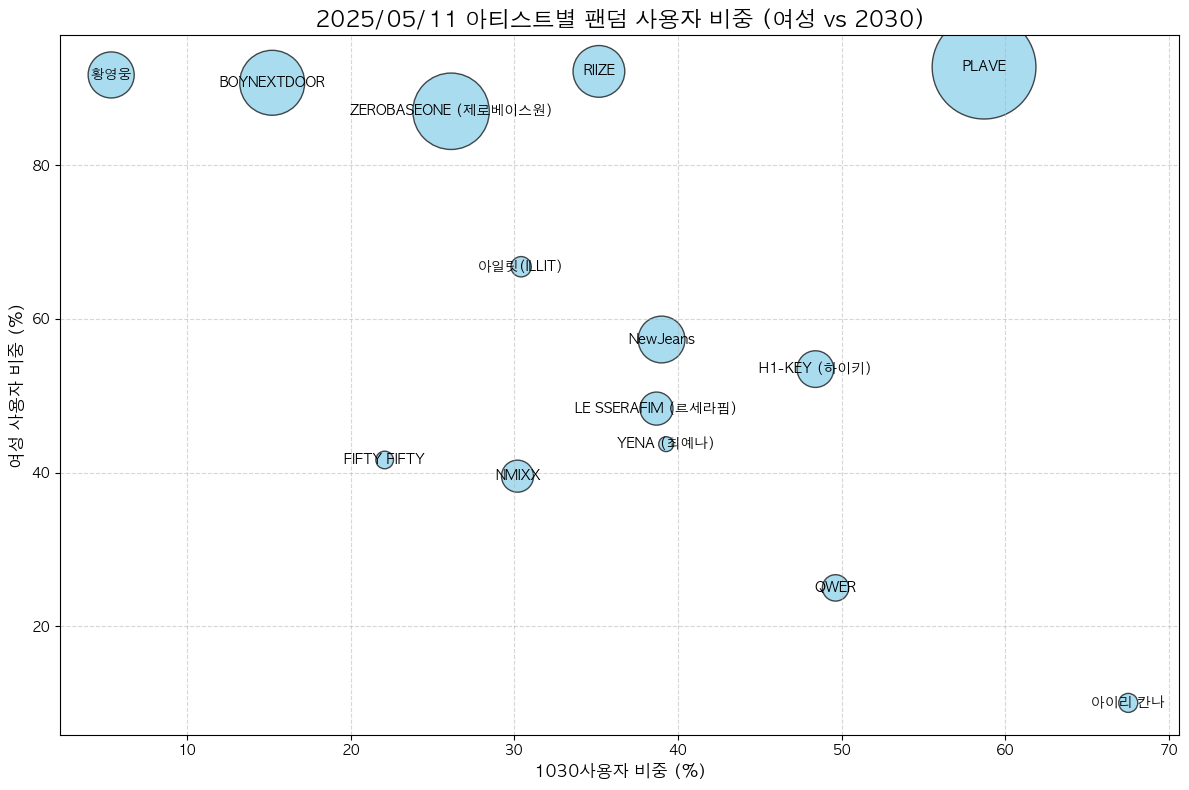

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# 'dt' 컬럼의 데이터 타입 확인
print(fandom_user_gndr['dt'].dtype)

# 'dt' 컬럼이 문자열이라면 datetime으로 변환
if fandom_user_gndr['dt'].dtype == 'object':
    fandom_user_gndr['dt'] = pd.to_datetime(fandom_user_gndr['dt'], errors='coerce')

# 2025/05/11 데이터 필터링
latest_date = '2025-05-11'
filtered_data = fandom_user_gndr[fandom_user_gndr['dt'] == latest_date].copy()


# Scatter plot 생성
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    filtered_data['age_102030_user_ratio'], 
    filtered_data['female_user_ratio'],     
    s=filtered_data['user_cnt'] / 10,  # 팬덤 사용자 수에 비례한 점 크기
    alpha=0.7, 
    c='skyblue', 
    edgecolor='black'
)

# 각 점에 아티스트 이름 추가
for i, row in filtered_data.iterrows():
    plt.text(
        row['age_102030_user_ratio'], 
        row['female_user_ratio'],         
        row['artist_name_web_list'], 
        fontsize=10, 
        ha='center', 
        va='center'
    )

# 그래프 꾸미기
plt.title('2025/05/11 아티스트별 팬덤 사용자 비중 (여성 vs 2030)', fontsize=16)
plt.xlabel('1030사용자 비중 (%)', fontsize=12)
plt.ylabel('여성 사용자 비중 (%)', fontsize=12)
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()

# 그래프 출력
plt.show()